##### <code> Classification using NN - Titanic Dataset  </code>

In [31]:
import numpy as np 
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from collections import Counter

In [32]:
# Load data
data = pd.read_csv("./titanic.csv")

# Store label
y = data["Survived"]

# Features - drop irrelevant columns
X = data.drop(columns=["Survived", "PassengerId", "Name", "Ticket", "Cabin"])

# Preprocess features
# Encode Sex
X['Sex'] = (X['Sex'] == 'male').astype(int)

# Fill Age missing values
X['Age'].fillna(X['Age'].median(), inplace=True)

# Normalize Fare
X["Fare"] = (X["Fare"] - X["Fare"].min()) / (X["Fare"].max() - X["Fare"].min())

# Encode Embarked
label_encoder = LabelEncoder()
X['Embarked'] = X['Embarked'].fillna(X['Embarked'].mode()[0])
X['Embarked'] = label_encoder.fit_transform(X['Embarked'])

# Check no NaN left
print("Any NaN left?", X.isna().sum().sum())

X.info()

Any NaN left? 0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    891 non-null    int64  
 1   Sex       891 non-null    int32  
 2   Age       891 non-null    float64
 3   SibSp     891 non-null    int64  
 4   Parch     891 non-null    int64  
 5   Fare      891 non-null    float64
 6   Embarked  891 non-null    int32  
dtypes: float64(2), int32(2), int64(3)
memory usage: 41.9 KB


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_9880\2423465061.py:15: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X['Age'].fillna(X['Age'].median(), inplace=True)


In [33]:
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from collections import Counter
from sklearn.model_selection import train_test_split

In [34]:
# Train/test split
xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size=0.1, random_state=42)

# Scale 
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(xtrain)
X_test_scaled  = scaler.transform(xtest)

# SMOTE
smote = SMOTE(random_state=42)
xtrain_sm, ytrain_sm = smote.fit_resample(X_train_scaled, ytrain)

c = Counter(ytrain_sm)
c


Counter({1: 495, 0: 495})

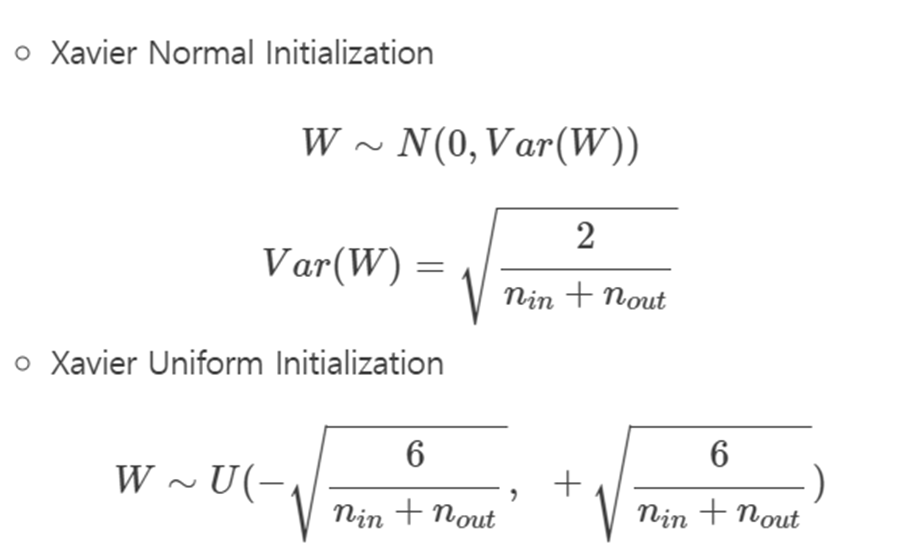

In [35]:
from numpy import ndarray

class NeuralNetwork:
    def __init__(self , X ,in_features=7 ,  hidden_layer_one=16, hidden_layer_two=8, out_features=1 , lr=0.005):
        # Use Xaiver initialization for Sigmoid
        self.w1 = np.random.randn(in_features, hidden_layer_one) * np.sqrt(2/(in_features + hidden_layer_one ))
        self.w2 = np.random.randn(hidden_layer_one, hidden_layer_two) *  np.sqrt(2/(hidden_layer_one + hidden_layer_two ))
        self.w3 = np.random.randn(hidden_layer_two, out_features) *  np.sqrt(2/(hidden_layer_two + out_features))
        
        self.b1 = np.zeros((1 , hidden_layer_one))
        self.b2 = np.zeros((1 , hidden_layer_two))
        self.b3 = np.zeros((1 , out_features))
        self.lr = lr
    
    def sigmoid(self, x:ndarray):
        return 1 / ( 1 + np.exp(-x) )
    
    # def sigmoid_derivative(self, x: ndarray):
    #     s = self.sigmoid(x)
    #     return s * (1 - s)


    def relu(self, x): 
        return np.maximum(0,x)

    def relu_derivative(self, x):
        return (x>0).astype(float)

    
    def forward(self , x:ndarray):
        self.z1 = x@self.w1 + self.b1
        self.A1 = self.relu(self.z1)
        self.z2 = self.A1@self.w2 + self.b2
        self.A2 = self.relu(self.z2)
        self.z3 = self.A2@self.w3 + self.b3
        self.y_hat =  self.sigmoid(self.z3)
        return self.y_hat
        
    def loss(self , y_hat:ndarray , y:ndarray): 
        y_hat = np.clip(y_hat, 1e-15, 1-1e-15)
        return -np.mean(y * np.log(y_hat) + (1 - y) * np.log(1 - y_hat))
        
    def backward(self, X , y_hat:ndarray , y:ndarray):
        m = y.shape[0]
        self.dz3 = (y_hat - y) 
        dw3 = self.A2.T @ self.dz3
        db3 = np.sum(self.dz3 , axis=0 )
        
        self.dA2 = self.dz3 @ self.w3.T
        self.dz2 = self.dA2 * self.relu_derivative(self.z2)
        dw2 = self.A1.T @ self.dz2
        db2 = np.sum(self.dz2 , axis=0 )
        
        
        self.dA1 = self.dz2 @ self.w2.T
        self.dz1 = self.dA1 * self.relu_derivative(self.z1)
        dw1 = X.T @ self.dz1
        db1 = np.sum(self.dz1 , axis=0 )
        
        return dw1 , db1 , dw2 , db2 , dw3,db3

    def optim(self, dw1, db1, dw2, db2, dw3, db3):
        self.w1 = self.w1 - self.lr*dw1
        self.w2 = self.w2 - self.lr*dw2
        self.w3 = self.w3 - self.lr*dw3
        
        self.b1 = self.b1 - self.lr*db1
        self.b2 = self.b2 - self.lr*db2
        self.b3 = self.b3 - self.lr*db3
        
    
    def train(self, xtrain:ndarray , ytrain:ndarray , epoch):
        
        
        for i in range(epoch):
            y_pred = self.forward(xtrain)
            dw1 , db1 , dw2 , db2 , dw3,db3 = self.backward( xtrain, y_pred , ytrain)
            self.optim( dw1, db1, dw2, db2, dw3, db3)
            if i % 1000 == 0 :
                print("Loss : " , self.loss(y_pred , ytrain))
                
                
    def predict(self, X):
        predictions = self.forward(X)
        return predictions     
    

from tabulate import tabulate
from sklearn.metrics import accuracy_score , confusion_matrix

def main():
    X_train = xtrain_sm
    X_test = X_test_scaled

    y_train = ytrain_sm.to_numpy().reshape(-1, 1)
    y_test = ytest.to_numpy().reshape(-1, 1)
    
    in_features = X_train.shape[1]
    
    nn = NeuralNetwork(
        X_train,
        in_features=in_features,
        hidden_layer_one=16,
        hidden_layer_two=8,
        out_features=1,
        lr=1e-3
    )
    
    nn.train(X_train, y_train, epoch=20000)
    
    preds = nn.predict(X_test).reshape(-1, 1)
    
    results = pd.DataFrame({
        'Actual': y_test.flatten(),
        'Predicted': (preds >= 0.5).astype(int).flatten()
    })
    
    acc = accuracy_score(ytest, (preds >= 0.5).astype(int).flatten())
    print("The accuracy is: ", round((acc * 100), 2), "%")
    
    cm = confusion_matrix(ytest, (preds >= 0.5).astype(int).flatten())
    
    print(tabulate(results.head(20), headers='keys', tablefmt='psql'))
    print("\nConfusion Matrix:")
    print(cm)


if __name__ == "__main__":
    main()


Loss :  0.6198804394841886
Loss :  0.35152220018042724
Loss :  0.3206398572789387
Loss :  0.3483622377859395
Loss :  0.2958463809288397
Loss :  0.2947226401562168
Loss :  0.29472064135240056
Loss :  0.28209752964198936
Loss :  0.24969930328558307
Loss :  0.26473922476792255
Loss :  0.2817150551373291
Loss :  0.24857664611601094
Loss :  0.2239439335315889
Loss :  0.2296476025844642
Loss :  0.2271471988247526
Loss :  0.2450068017999363
Loss :  0.22788482631849313
Loss :  0.21936060171891233
Loss :  0.22255930163700055
Loss :  0.2076025513965973
The accuracy is:  83.33 %
+----+----------+-------------+
|    |   Actual |   Predicted |
|----+----------+-------------|
|  0 |        1 |           1 |
|  1 |        0 |           0 |
|  2 |        0 |           0 |
|  3 |        1 |           1 |
|  4 |        1 |           1 |
|  5 |        1 |           1 |
|  6 |        1 |           1 |
|  7 |        0 |           0 |
|  8 |        1 |           1 |
|  9 |        1 |           1 |
| 10 |   

In [36]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score , confusion_matrix

LR = LogisticRegression()
LR.fit(xtrain_sm , ytrain_sm)
ypred = LR.predict(xtest)

acc = accuracy_score(ytest , ypred)
cm =  confusion_matrix(ytest , ypred)

results = pd.DataFrame({
    "actual":ytest,
    "pred" :ypred
})
    
print(tabulate(results.head(20), headers='keys', tablefmt='psql'))
acc



+-----+----------+--------+
|     |   actual |   pred |
|-----+----------+--------|
| 709 |        1 |      0 |
| 439 |        0 |      0 |
| 840 |        0 |      0 |
| 720 |        1 |      0 |
|  39 |        1 |      0 |
| 290 |        1 |      0 |
| 300 |        1 |      0 |
| 333 |        0 |      0 |
| 208 |        1 |      0 |
| 136 |        1 |      0 |
| 137 |        0 |      0 |
| 696 |        0 |      0 |
| 485 |        0 |      0 |
| 244 |        0 |      0 |
| 344 |        0 |      0 |
| 853 |        1 |      0 |
| 621 |        1 |      0 |
| 653 |        1 |      0 |
| 886 |        0 |      0 |
| 110 |        0 |      0 |
+-----+----------+--------+


c:\Users\LENOVO\anaconda3\envs\torchgpu\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


0.6